# Nuclei Size Classification

We first started with unsupervised classification of nuclei into three or two sizes. This yielded a threshold around 180 um^2 to distinguish the big nuclei from the medium and small, but this might not have a lot of biological meaning.

We then went for supervised classification and for this Afshan selected small and big nuclei from the WT organoids. We still have to solve the question whether it makes sense to get the big nuclei from the WT or if the big nuclei are only present in the Ndr.

In [56]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [57]:
DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining Non-IGF1 exp')

In [58]:
def parse_condition(text):
    if 'wt' in text.lower():
        return 'WT'
    elif 'ndr' in text.lower():
        return 'Ndr'
    else:
        raise ValueError

def parse_cell_line(text):
    return text.split(' ')[0][-4:]

def parse_region(text):
    if 'peri' in text.lower():
        return 'Peripheral'
    elif 'hilar' in text.lower():
        return 'Hilar'
    else:
        raise ValueError
        
def parse_sample_number(text):
    return text.split('-')[-1]

In [59]:
def load_dataset(filename):
    nuclei_sizes = pd.read_excel(DATA_DIR / filename, sheet_name=None)
    dfs = []
    for size_class, size_df in nuclei_sizes.items():
        size_df.drop(columns=['Unnamed: 0'], inplace=True)
        size_df['size_class'] = size_class
        dfs.append(size_df)

    nuclei_sizes = pd.concat(dfs, ignore_index=True)
    
    nuclei_sizes['condition'] = nuclei_sizes.sample_name.apply(parse_condition)
    nuclei_sizes['cell_line'] = nuclei_sizes.sample_name.apply(parse_cell_line)
    nuclei_sizes['region'] = nuclei_sizes.sample_name.apply(parse_region)
    nuclei_sizes['sample_number'] = nuclei_sizes.sample_name.apply(parse_sample_number)

    nuclei_sizes = nuclei_sizes.astype({'label': int, 'condition': 'category', 'cell_line': 'category', 'region': 'category', 'sample_number': 'category'})
    
    return nuclei_sizes

In [60]:
def get_area(condition, cell_line, region, sample_number, label):
    area = nuclei_size_original.query(f'condition == "{condition}" and cell_line == "{cell_line}" and region == "{region}" and sample_number == "{sample_number}" and label == {label}').area.values
    if len(area) == 1:
        return area[0]
    else:
        print(f'condition == "{condition}" and cell_line == "{cell_line}" and region == "{region}" and sample_number == "{sample_number}" and label == {label}')
        print(area)
        return np.nan

In [61]:
def get_trained_classifier(nuclei_sizes):
    clf = LogisticRegression(penalty='none', class_weight='balanced')
    clf = clf.fit(nuclei_sizes.area.values.reshape(-1, 1), nuclei_sizes.size_class.values)
    return clf

In [62]:
def assess_classifier(nuclei_sizes, clf):
    fig, ax1 = plt.subplots()
    
    sns.histplot(data=nuclei_sizes, x='area', hue='size_class', bins=np.arange(0, 650, 10), stat='density', common_norm=False, ax=ax1)
    
    probas = clf.predict_proba(np.arange(0,np.ceil(nuclei_sizes.area.max())).reshape(-1, 1))
    
    ax2 = ax1.twinx()
    ax2.plot(probas[:, 1])
    ax2.plot(probas[:, 0])
    ax2.set_ylim((0, 1))
    threshold = np.argmin(np.abs(probas[:, 0] - probas[:, 1]))
    plt.axvline(x=threshold, color='k', linestyle='--')
    plt.show()
    
    print('Score: %f.4' % clf.score(nuclei_sizes.area.values.reshape(-1, 1), nuclei_sizes.size_class.values))
    print('Threshold: %d' % threshold)

## Load all nuclei size dataframe

In [63]:
nuclei_size_original = pd.read_excel(DATA_DIR / 'nuclei_size.xlsx', sheet_name=None)
dfs = []
for sample_name, sample_df in nuclei_size_original.items():
    sample_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
    sample_df['sample_name'] = sample_name
    dfs.append(sample_df)

nuclei_size_original = pd.concat(dfs, ignore_index=True)

In [64]:
nuclei_size_original['condition'] = nuclei_size_original.sample_name.apply(parse_condition)
nuclei_size_original['cell_line'] = nuclei_size_original.sample_name.apply(parse_cell_line)
nuclei_size_original['region'] = nuclei_size_original.sample_name.apply(parse_region)
nuclei_size_original['sample_number'] = nuclei_size_original.sample_name.apply(parse_sample_number)

nuclei_size_original = nuclei_size_original.astype({'label': int, 'condition': 'category', 'cell_line': 'category', 'region': 'category', 'sample_number': 'category'})

In [65]:
nuclei_size_original

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,area,volume,sample_name,condition,cell_line,region,sample_number
0,1036,0.572159,36.319088,17185.166988,2,3,7322,10333.292133,79.040874,2234.506880,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
1,765,0.443916,31.209426,14916.526797,4,5,3966,10774.640696,58.365124,1210.332462,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
2,638,0.778079,28.501348,12053.150470,9,3,3742,7978.092197,48.675751,1141.972787,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
3,711,0.623056,30.087760,17123.690577,10,3,5060,10684.135968,54.245233,1544.196232,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
4,528,0.805742,25.928179,12609.446970,11,5,2418,9111.187758,40.283380,737.918279,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92810,121,0.916938,12.412171,26513.140496,3511,5,121,26513.140496,18.840016,113.040097,WT1225 Periph-9,WT,1225,Peripheral,9
92811,142,0.848895,13.446190,10091.507042,3512,5,142,10091.507042,22.109771,132.658626,WT1225 Periph-9,WT,1225,Peripheral,9
92812,268,0.844165,18.472363,10178.410448,3517,5,268,10178.410448,41.728300,250.369801,WT1225 Periph-9,WT,1225,Peripheral,9
92813,83,0.653466,10.280023,10708.361446,3520,5,83,10708.361446,12.923317,77.539901,WT1225 Periph-9,WT,1225,Peripheral,9


## Wild-Type only analysis

In [14]:
nuclei_sizes = load_dataset('20230320_manual_nuclei_classification.xlsx')

In [15]:
nuclei_sizes

,sample_name,label,size_class,condition,cell_line,region,sample_number
0,Wt1221 hilar-7,321,small,WT,1221,Hilar,7
1,Wt1221 hilar-7,36,small,WT,1221,Hilar,7
2,Wt1221 hilar-7,557,small,WT,1221,Hilar,7
3,Wt1221 hilar-7,200,small,WT,1221,Hilar,7
4,Wt1221 hilar-7,1749,small,WT,1221,Hilar,7
...,...,...,...,...,...,...,...
257,Wt1225 hilar-13,120,big,WT,1225,Hilar,13
258,Wt1225 hilar-13,27,big,WT,1225,Hilar,13
259,Wt1225 hilar-13,15,big,WT,1225,Hilar,13
260,Wt1225 hilar-13,152,big,WT,1225,Hilar,13


In [16]:
nuclei_sizes['area'] = nuclei_sizes.apply(lambda x: get_area(x['condition'], x['cell_line'], x['region'], x['sample_number'], x['label']), axis=1)

condition == "WT" and cell_line == "1221" and region == "Peripheral" and sample_number == "8" and label == 86
[]
condition == "WT" and cell_line == "1221" and region == "Peripheral" and sample_number == "8" and label == 58
[]
condition == "WT" and cell_line == "1221" and region == "Peripheral" and sample_number == "8" and label == 113
[]
condition == "WT" and cell_line == "1221" and region == "Peripheral" and sample_number == "8" and label == 78
[]
condition == "WT" and cell_line == "1223" and region == "Hilar" and sample_number == "8" and label == 208
[]
condition == "WT" and cell_line == "1223" and region == "Hilar" and sample_number == "8" and label == 38
[]
condition == "WT" and cell_line == "1223" and region == "Hilar" and sample_number == "8" and label == 195
[]
condition == "WT" and cell_line == "1223" and region == "Hilar" and sample_number == "8" and label == 337
[]
condition == "WT" and cell_line == "1223" and region == "Hilar" and sample_number == "8" and label == 90
[]
cond

In [17]:
nuclei_sizes.dropna(subset='area', inplace=True)

<Axes: xlabel='area', ylabel='Count'>

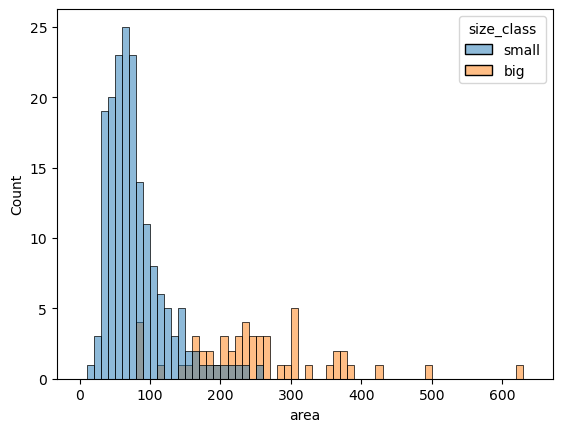

In [18]:
sns.histplot(data=nuclei_sizes, x='area', hue='size_class', bins=np.arange(0, 650, 10))

In [262]:
print(nuclei_sizes.groupby('size_class')['condition'].count())

size_class
big       53
small    178
Name: condition, dtype: int64


In [228]:
clf = get_trained_classifier(nuclei_sizes)

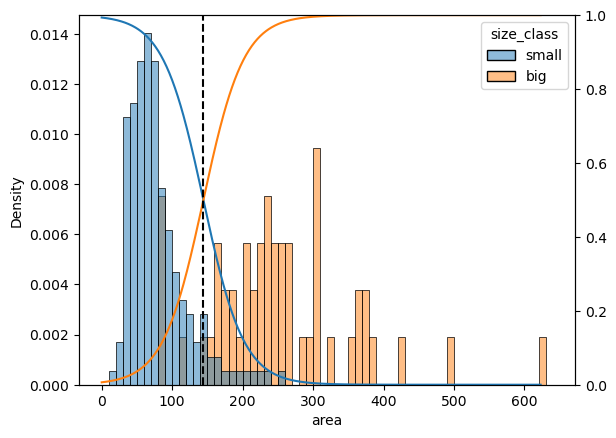

Score: 0.913420.4
Threshold: 144


In [235]:
assess_classifier(nuclei_sizes, clf)

In [242]:
nuclei_size_test = nuclei_sizes.drop(nuclei_sizes.query('size_class == "big" and area < 150').index)
nuclei_size_test = nuclei_size_test.drop(nuclei_size_test.query('size_class == "small" and area > 180').index)
# nuclei_size_test = nuclei_size_test.drop(nuclei_size_test.query('sample_name == "Wt1225 hilar-13"').index)

In [243]:
nuclei_size_test

,sample_name,label,size_class,condition,cell_line,region,sample_number,area
0,Wt1221 hilar-7,321,small,WT,1221,Hilar,7,38.280655
1,Wt1221 hilar-7,36,small,WT,1221,Hilar,7,80.681201
2,Wt1221 hilar-7,557,small,WT,1221,Hilar,7,37.937331
3,Wt1221 hilar-7,200,small,WT,1221,Hilar,7,40.168939
4,Wt1221 hilar-7,1749,small,WT,1221,Hilar,7,58.193462
...,...,...,...,...,...,...,...,...
257,Wt1225 hilar-13,120,big,WT,1225,Hilar,13,387.098104
258,Wt1225 hilar-13,27,big,WT,1225,Hilar,13,268.136248
259,Wt1225 hilar-13,15,big,WT,1225,Hilar,13,302.983660
260,Wt1225 hilar-13,152,big,WT,1225,Hilar,13,256.806547


In [244]:
clf = get_trained_classifier(nuclei_size_test)

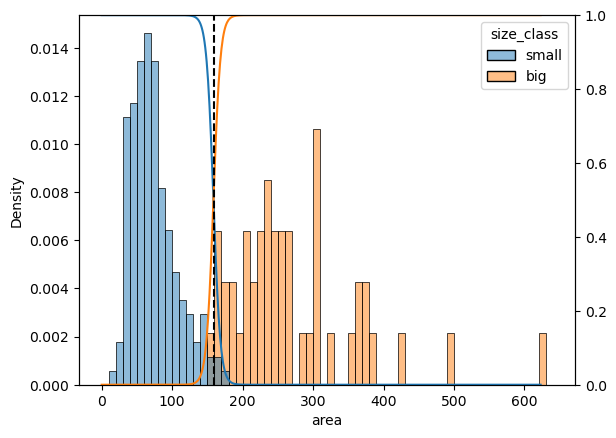

Score: 0.986239.4
Threshold: 159


In [245]:
assess_classifier(nuclei_size_test, clf)

In [247]:
nuclei_sizes.query('size_class == "small" and area > 150').sort_values('area')

,sample_name,label,size_class,condition,cell_line,region,sample_number,area
178,Wt1225 hilar-13,49,small,WT,1225,Hilar,13,150.032702
29,Wt1221 hilar-10,20,small,WT,1221,Hilar,10,154.114446
150,Wt1225 hilar-5,104,small,WT,1225,Hilar,5,161.163785
141,Wt1225 hilar-4,333,small,WT,1225,Hilar,4,169.108479
151,Wt1225 hilar-5,232,small,WT,1225,Hilar,5,172.513348
171,Wt1225 hilar-13,21,small,WT,1225,Hilar,13,181.446872
149,Wt1225 hilar-5,23,small,WT,1225,Hilar,5,193.510038
152,Wt1225 hilar-5,63,small,WT,1225,Hilar,5,208.264469
148,Wt1225 hilar-5,126,small,WT,1225,Hilar,5,211.101860
145,Wt1225 hilar-5,19,small,WT,1225,Hilar,5,229.261160


## Nodder analysis

In [51]:
ndr_nuclei_sizes = load_dataset('20230322_manual_nuclei_classification_Ndr.xlsx')

In [54]:
ndr_nuclei_sizes

,sample_name,label,size_class,condition,cell_line,region,sample_number
0,Ndr1219 p8 Hilar-6,27,small,Ndr,1219,Hilar,6
1,Ndr1219 p8 Hilar-6,15,small,Ndr,1219,Hilar,6
2,Ndr1219 p8 Hilar-6,31,small,Ndr,1219,Hilar,6
3,Ndr1219 p8 Hilar-6,35,small,Ndr,1219,Hilar,6
4,Ndr1219 p8 Hilar-6,41,small,Ndr,1219,Hilar,6
...,...,...,...,...,...,...,...
111,Ndr1224 Hilar-6,4,big,Ndr,1224,Hilar,6
112,Ndr1224 Hilar-6,19,big,Ndr,1224,Hilar,6
113,Ndr1224 Hilar-6,35,big,Ndr,1224,Hilar,6
114,Ndr1224 Hilar-6,9,big,Ndr,1224,Hilar,6


In [55]:
ndr_nuclei_sizes['area'] = ndr_nuclei_sizes.apply(lambda x: get_area(x['condition'], x['cell_line'], x['region'], x['sample_number'], x['label']), axis=1)

condition == "Ndr" and cell_line == "1219" and region == "Hilar" and sample_number == "10" and label == 15
[]
condition == "Ndr" and cell_line == "1219" and region == "Hilar" and sample_number == "11" and label == 18
[]
condition == "Ndr" and cell_line == "1219" and region == "Peripheral" and sample_number == "4" and label == 6
[]
condition == "Ndr" and cell_line == "1219" and region == "Peripheral" and sample_number == "4" and label == 16
[]
condition == "Ndr" and cell_line == "1219" and region == "Peripheral" and sample_number == "4" and label == 54
[]
condition == "Ndr" and cell_line == "1219" and region == "Peripheral" and sample_number == "4" and label == 35
[]
condition == "Ndr" and cell_line == "1219" and region == "Peripheral" and sample_number == "4" and label == 38
[]
condition == "Ndr" and cell_line == "1220" and region == "Hilar" and sample_number == "19 full " and label == 6
[]
condition == "Ndr" and cell_line == "1220" and region == "Hilar" and sample_number == "19 full "

In [56]:
ndr_nuclei_sizes.dropna(subset='area', inplace=True)

In [61]:
ndr_nuclei_sizes.query('size_class == "big"').sort_values('area').head(10)

,sample_name,label,size_class,condition,cell_line,region,sample_number,area
90,Ndr1220 hilar repeat EdU DAPI-3,9,big,Ndr,1220,Hilar,3,118.044206
62,Ndr1219 p8 Hilar-6,7,big,Ndr,1219,Hilar,6,130.930140
91,Ndr1220 hilar repeat EdU DAPI-3,668,big,Ndr,1220,Hilar,3,132.243419
61,Ndr1219 p8 Hilar-6,1,big,Ndr,1219,Hilar,6,173.804474
88,Ndr1220 hilar repeat EdU DAPI-3,249,big,Ndr,1220,Hilar,3,202.179843
110,Ndr1224 Hilar-2,13,big,Ndr,1224,Hilar,2,268.354534
60,Ndr1219 p8 Hilar-6,16,big,Ndr,1219,Hilar,6,294.956739
59,Ndr1219 p8 Hilar-6,10,big,Ndr,1219,Hilar,6,324.070637
93,Ndr1220 hilar repeat EdU DAPI-3,701,big,Ndr,1220,Hilar,3,347.774761
92,Ndr1220 hilar repeat EdU DAPI-3,980,big,Ndr,1220,Hilar,3,361.973974


<AxesSubplot:xlabel='area', ylabel='Count'>

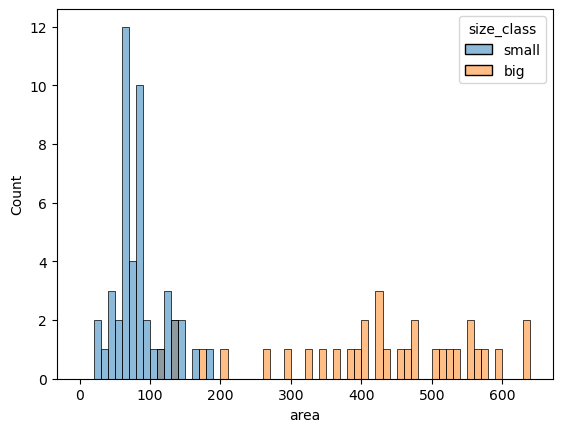

In [263]:
sns.histplot(data=ndr_nuclei_sizes, x='area', hue='size_class', bins=np.arange(0, 650, 10))

In [264]:
print(ndr_nuclei_sizes.groupby('size_class')['condition'].count())

size_class
big      46
small    47
Name: condition, dtype: int64


In [265]:
clf = get_trained_classifier(ndr_nuclei_sizes)

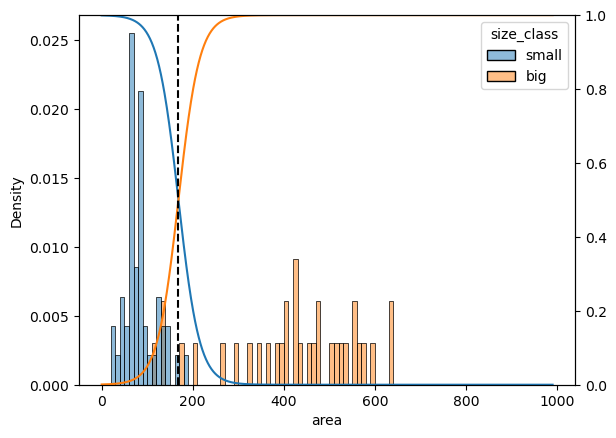

Score: 0.946237.4
Threshold: 168


In [266]:
assess_classifier(ndr_nuclei_sizes, clf)

## Combining Ndr and WT

In [267]:
all_nuclei_sizes = pd.concat([nuclei_sizes, ndr_nuclei_sizes], ignore_index=True)

In [268]:
all_nuclei_sizes

,sample_name,label,size_class,condition,cell_line,region,sample_number,area
0,Wt1221 hilar-7,321,small,WT,1221,Hilar,7,38.280655
1,Wt1221 hilar-7,36,small,WT,1221,Hilar,7,80.681201
2,Wt1221 hilar-7,557,small,WT,1221,Hilar,7,37.937331
3,Wt1221 hilar-7,200,small,WT,1221,Hilar,7,40.168939
4,Wt1221 hilar-7,1749,small,WT,1221,Hilar,7,58.193462
...,...,...,...,...,...,...,...,...
319,Ndr1224 Hilar-6,4,big,Ndr,1224,Hilar,6,694.857530
320,Ndr1224 Hilar-6,19,big,Ndr,1224,Hilar,6,698.716319
321,Ndr1224 Hilar-6,35,big,Ndr,1224,Hilar,6,716.494308
322,Ndr1224 Hilar-6,9,big,Ndr,1224,Hilar,6,464.708368


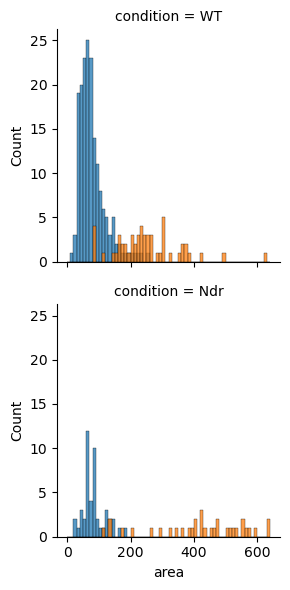

In [273]:
g = sns.FacetGrid(all_nuclei_sizes, row='condition', hue='size_class')
g = (g.map(sns.histplot, "area", bins=np.arange(0, 650, 10)))

<AxesSubplot:xlabel='area', ylabel='Count'>

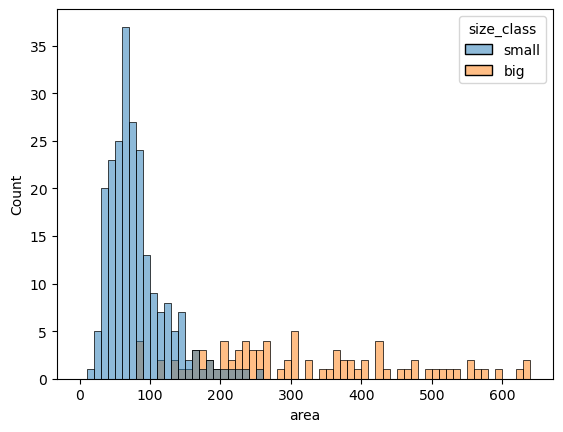

In [274]:
sns.histplot(data=all_nuclei_sizes, x='area', hue='size_class', bins=np.arange(0, 650, 10))

In [275]:
print(all_nuclei_sizes.groupby('size_class')['condition'].count())

size_class
big       99
small    225
Name: condition, dtype: int64


In [276]:
clf = get_trained_classifier(all_nuclei_sizes)

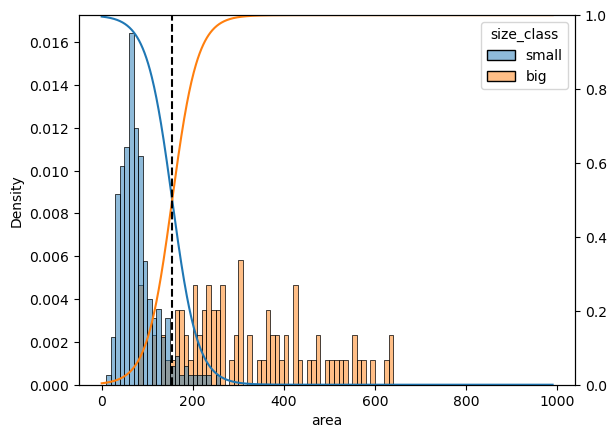

Score: 0.935185.4
Threshold: 155


In [277]:
assess_classifier(all_nuclei_sizes, clf)

In [288]:
all_nuclei_sizes_test = all_nuclei_sizes.drop(all_nuclei_sizes.query('size_class == "big" and condition == "WT"').index)
all_nuclei_sizes_test = all_nuclei_sizes_test.drop(all_nuclei_sizes_test.query('area > 800').index)

<AxesSubplot:xlabel='area', ylabel='Count'>

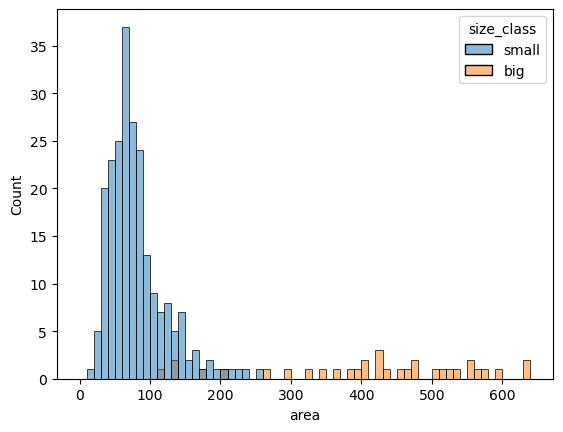

In [289]:
sns.histplot(data=all_nuclei_sizes_test, x='area', hue='size_class', bins=np.arange(0, 650, 10))

In [301]:
print(all_nuclei_sizes_test.groupby('size_class')['condition'].count())

size_class
big       46
small    178
Name: condition, dtype: int64


In [302]:
clf = get_trained_classifier(all_nuclei_sizes_test)

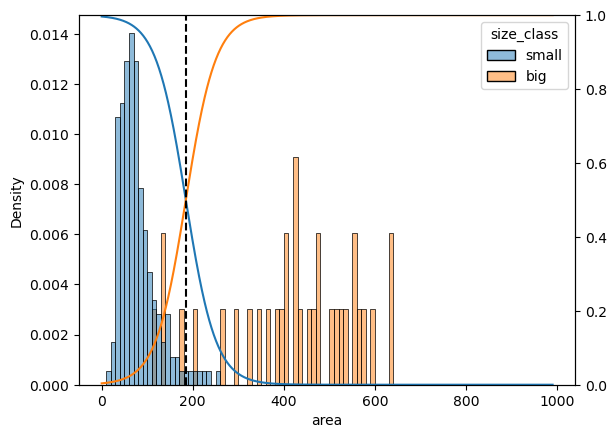

Score: 0.955357.4
Threshold: 185


In [303]:
assess_classifier(all_nuclei_sizes_test, clf)

In [293]:
all_nuclei_sizes.iloc[296]

sample_name      Ndr1219 p8 peripheral-4
label                                 22
size_class                           big
condition                            Ndr
cell_line                           1219
region                        Peripheral
sample_number                          4
area                          990.757523
Name: 296, dtype: object

In [295]:
all_nuclei_sizes.query('size_class == "big" and area < 180').sort_values('area')

,sample_name,label,size_class,condition,cell_line,region,sample_number,area
186,Wt1221 hilar-2,599,big,WT,1221,Hilar,2,81.079458
183,Wt1221 hilar-2,361,big,WT,1221,Hilar,2,85.364144
185,Wt1221 hilar-2,677,big,WT,1221,Hilar,2,87.891011
208,Wt1223 peripheral-5,48,big,WT,1223,Peripheral,5,88.573596
182,Wt1221 hilar-2,128,big,WT,1221,Hilar,2,111.182129
302,Ndr1220 hilar repeat EdU DAPI-3,9,big,Ndr,1220,Hilar,3,118.044206
281,Ndr1219 p8 Hilar-6,7,big,Ndr,1219,Hilar,6,130.930140
303,Ndr1220 hilar repeat EdU DAPI-3,668,big,Ndr,1220,Hilar,3,132.243419
180,Wt1221 hilar-10,11,big,WT,1221,Hilar,10,149.460495
187,Wt1221 hilar-2,1063,big,WT,1221,Hilar,2,158.863002


## Albumin+ nuclei vs WT small

We can used the detected size of Alb+ nuclei and use this to generate a threshold from the WT small and medium nuclei.

In [134]:
alb_nuclei_sizes = pd.read_excel(DATA_DIR / 'Reference images for Alb+ve nuclei in ICOs/20230403_alb_pos_cells_areas.xlsx')

In [268]:
alb_nuclei_sizes['size_class'] = 'big'
alb_nuclei_sizes['condition'] = 'alb+'

# this_df = nuclei_size_original.query('condition == "WT"')
# this_df['size_class'] = 'small'

this_df = nuclei_sizes.drop(nuclei_sizes.query('size_class == "big"').index)
# this_df = this_df.drop(this_df.query('sample_name == "Wt1225 hilar-5"').index)

test_nuclei_sizes = pd.concat([alb_nuclei_sizes.query('area > 130'), 
                               this_df],
                              ignore_index=True)

<Axes: xlabel='area', ylabel='Count'>

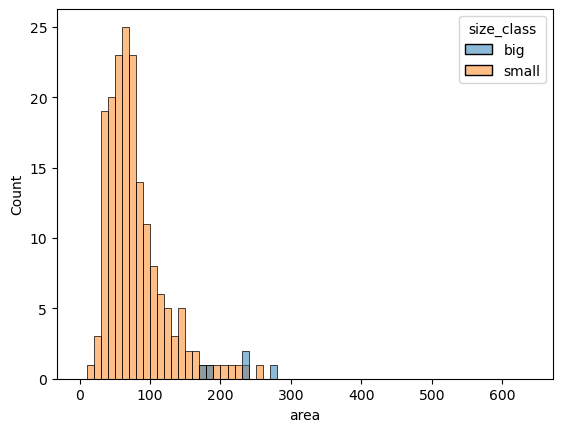

In [269]:
sns.histplot(data=test_nuclei_sizes, x='area', hue='size_class', bins=np.arange(0, 650, 10))

In [270]:
print(test_nuclei_sizes.groupby('size_class').count())

            Unnamed: 0  sample_name  label  plane  area  condition  cell_line  \
size_class                                                                      
big                  5            5      5      5     5          5          0   
small                0          178    178      0   178        178        178   

            region  sample_number  
size_class                         
big              0              0  
small          178            178  


In [271]:
test_nuclei_sizes.sort_values('area').tail(10)

,Unnamed: 0,sample_name,label,plane,area,size_class,condition,cell_line,region,sample_number
3,3.0,DAPI022,1289,28.0,181.726361,big,alb+,NaN,NaN,NaN
129,NaN,Wt1225 hilar-5,23,NaN,193.510038,small,WT,1225,Hilar,5
132,NaN,Wt1225 hilar-5,63,NaN,208.264469,small,WT,1225,Hilar,5
128,NaN,Wt1225 hilar-5,126,NaN,211.101860,small,WT,1225,Hilar,5
125,NaN,Wt1225 hilar-5,19,NaN,229.261160,small,WT,1225,Hilar,5
133,NaN,Wt1225 hilar-5,100,NaN,232.098550,small,WT,1225,Hilar,5
4,4.0,DAPI022,1369,30.0,234.296410,big,alb+,NaN,NaN,NaN
0,0.0,DAPI021,160,3.0,237.173929,big,alb+,NaN,NaN,NaN
127,NaN,Wt1225 hilar-5,107,NaN,254.797675,small,WT,1225,Hilar,5
2,2.0,DAPI021,2999,29.0,273.142910,big,alb+,NaN,NaN,NaN


In [272]:
def get_trained_classifier(nuclei_sizes):
    # balanced
    # clf = LogisticRegression(penalty='none', class_weight='balanced')
    # balanced plus extra weight to some class
    clf = LogisticRegression(penalty='none', class_weight={'big': 1/len(nuclei_sizes.query('size_class == "big"')), 'small': 10/len(nuclei_sizes.query('size_class == "small"'))})
    # unbalanced
    # clf = LogisticRegression(penalty='none', class_weight={'big': 1, 'small': 1})
    clf = clf.fit(nuclei_sizes.area.values.reshape(-1, 1), nuclei_sizes.size_class.values)
    return clf

In [273]:
clf = get_trained_classifier(test_nuclei_sizes)

C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


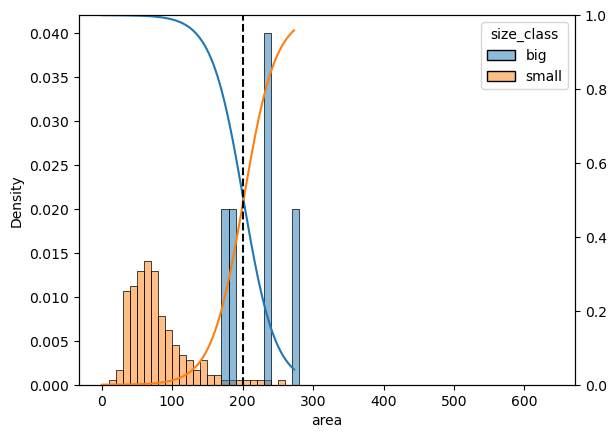

Score: 0.961749.4
Threshold: 201


In [274]:
assess_classifier(test_nuclei_sizes, clf)

In [182]:
test_nuclei_sizes.query('size_class == "big"')

,Unnamed: 0,sample_name,label,plane,area,size_class,condition,cell_line,region,sample_number
0,0.0,DAPI021,160,3.0,237.173929,big,alb+,NaN,NaN,NaN
1,1.0,DAPI021,2744,28.0,178.184799,big,alb+,NaN,NaN,NaN
2,2.0,DAPI021,2999,29.0,273.142910,big,alb+,NaN,NaN,NaN
3,3.0,DAPI022,1289,28.0,181.726361,big,alb+,NaN,NaN,NaN
4,4.0,DAPI022,1369,30.0,234.296410,big,alb+,NaN,NaN,NaN
5,5.0,DAPI037,1458,2.0,115.543435,big,alb+,NaN,NaN,NaN
6,6.0,DAPI037,2312,4.0,69.835160,big,alb+,NaN,NaN,NaN
7,7.0,DAPI038,367,3.0,93.740699,big,alb+,NaN,NaN,NaN


# Fitting Histograms

<AxesSubplot:xlabel='area', ylabel='Count'>

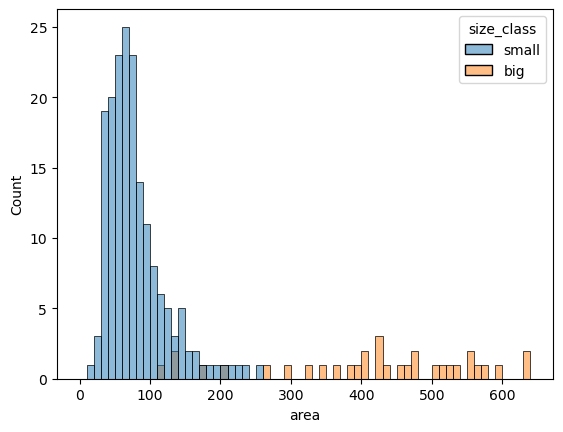

In [297]:
sns.histplot(data=all_nuclei_sizes.query('(condition == "WT" and size_class == "small") or (condition == "Ndr" and size_class == "big")'), x='area', hue='size_class', bins=np.arange(0, 650, 10))

<AxesSubplot:xlabel='area', ylabel='Count'>

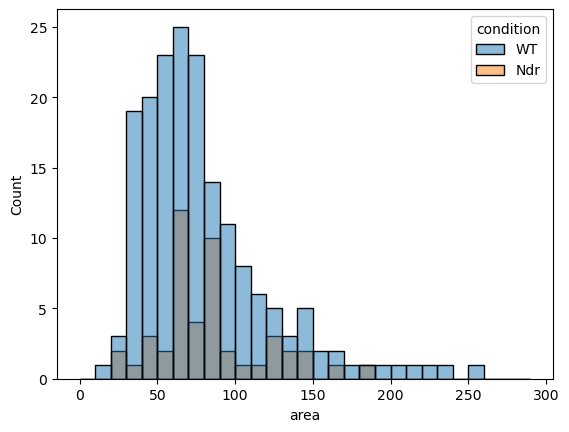

In [299]:
sns.histplot(data=all_nuclei_sizes.query('(condition == "WT" and size_class == "small") or (condition == "Ndr" and size_class == "small")'), x='area', hue='condition', bins=np.arange(0, 300, 10))

In [300]:
all_nuclei_sizes_test = all_nuclei_sizes.query('(condition == "WT" and size_class == "small") or (condition == "Ndr" and size_class == "big")')

<AxesSubplot:xlabel='area', ylabel='Count'>

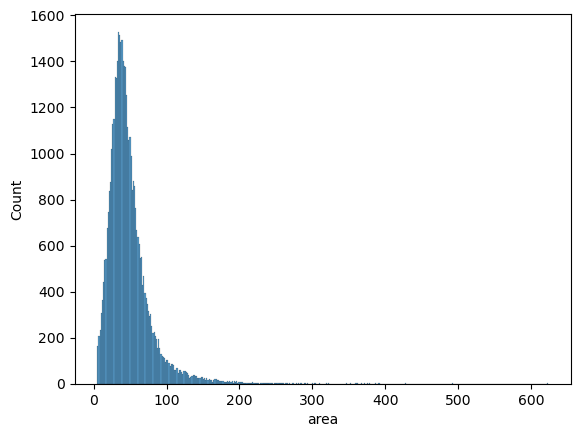

In [11]:
sns.histplot(data=nuclei_size_original.query('condition == "WT"'), x='area')

In [12]:
mean = np.mean(nuclei_size_original.query('condition == "WT"').area.values)
std = np.std(nuclei_size_original.query('condition == "WT"').area.values)

In [13]:
print(mean, std)


48.25957492483659 29.793400279085937


In [14]:
from scipy.stats import lognorm, norm, gamma, exponweib, loglaplace

(0.0, 200.0)

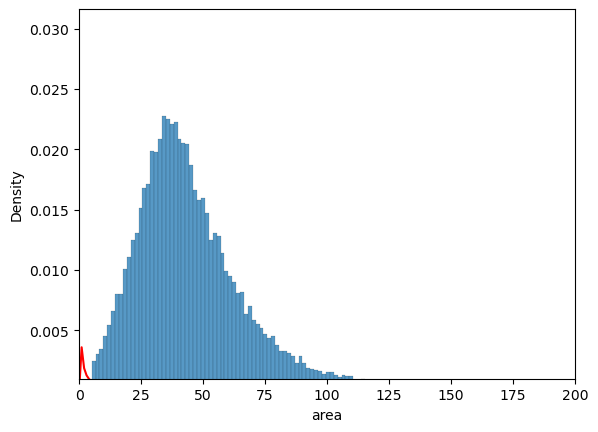

In [15]:
sns.histplot(data=nuclei_size_original.query('condition == "WT"'), x='area', stat='density')
x = np.arange(0, nuclei_size_original.area.max())
rv = lognorm(s=std, scale=np.exp(mean), loc=0)

plt.plot(x, rv.pdf(x), color='r')
plt.ylim((10 ** -3, 10 ** -1.5))
plt.xlim((0, 200))

(array(48.25957443), array(887.64647657), array(2.80103249), array(16.5927138))
48.25957492483659 887.6467001898379


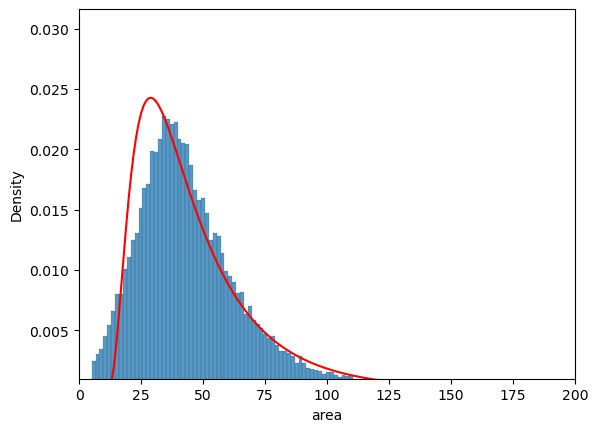

In [19]:
vals = nuclei_size_original.query('condition == "WT"').area.values
shape, loc, scale = lognorm.fit(vals, np.std(np.log(vals)), loc=-5, method='MM')
rv = lognorm(s=shape, loc=loc, scale=scale)

sns.histplot(data=nuclei_size_original.query('condition == "WT"'), x='area', stat='density')
x = np.arange(0, nuclei_size_original.area.max())

plt.plot(x, rv.pdf(x), color='r')
plt.ylim((10 ** -3, 10 ** -1.5))
plt.xlim((0, 200))

print(rv.stats(moments='mvsk'))
print(np.mean(vals), np.std(vals)**2)

In [25]:
print('99 percent prob of being WT nuclei: %f' % rv.ppf(0.99))
print('95th percentile of WT nuclei: %f' % np.quantile(nuclei_size_original.query('condition == "WT"').area.values, 0.95))
print('99th percentile of WT nuclei: %f' % np.quantile(nuclei_size_original.query('condition == "WT"').area.values, 0.99))

99 percent prob of being WT nuclei: 159.713640
95th percentile of WT nuclei: 101.452319
99th percentile of WT nuclei: 162.286794


(array(3.72327928), array(0.31182692), array(0.), array(0.))
3.7232792828892185 0.3118269196001047


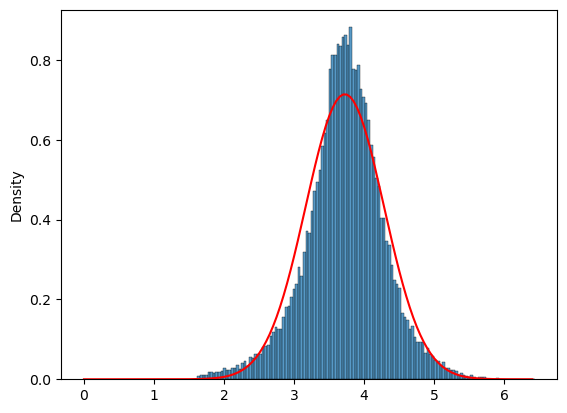

In [485]:
vals = np.log(nuclei_size_original.query('condition == "WT"').area.values)
params = norm.fit(vals, method='MM')
rv = norm(*params)

sns.histplot(x=vals, stat='density')
x = np.arange(0, vals.max(), 0.05)

plt.plot(x, rv.pdf(x), color='r')
# plt.ylim((10 ** -3, 10 ** -1.5))
# plt.xlim((0, 200))

print(rv.stats(moments='mvsk'))
print(np.mean(vals), np.std(vals)**2)

(array(47.47199114), array(1024.23864021), array(1.84523992), array(5.10736552))
48.25957492483659 887.6467001898379


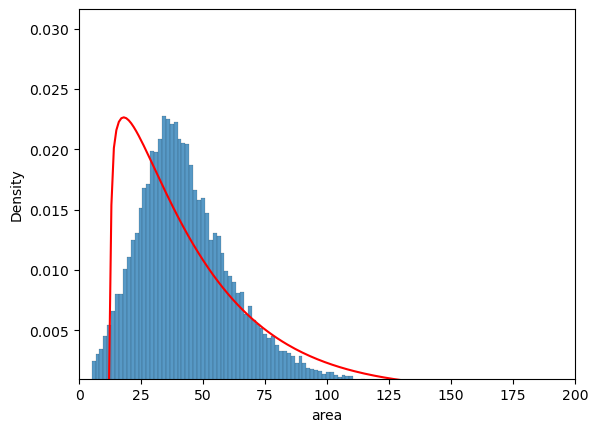

In [491]:
vals = nuclei_size_original.query('condition == "WT"').area.values
params = gamma.fit(vals, 10, method='MM')

sns.histplot(data=nuclei_size_original.query('condition == "WT"'), x='area', stat='density')
x = np.arange(0, nuclei_size_original.area.max())
rv = gamma(*params)

plt.plot(x, rv.pdf(x), color='r')
plt.ylim((10 ** -3, 10 ** -1.5))
plt.xlim((0, 200))

print(rv.stats(moments='mvsk'))
print(np.mean(vals), np.std(vals)**2)

C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\scipy\stats\_distn_infrastructure.py:2033: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\agucor\Anaconda3\envs\organoids\lib\site-packages\scipy\stats\_distn_infrastructure.py:2033: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


(array(48.3235684), array(875.15963496), array(2.92341452), array(17.31516617))
48.25957492483659 887.6467001898379


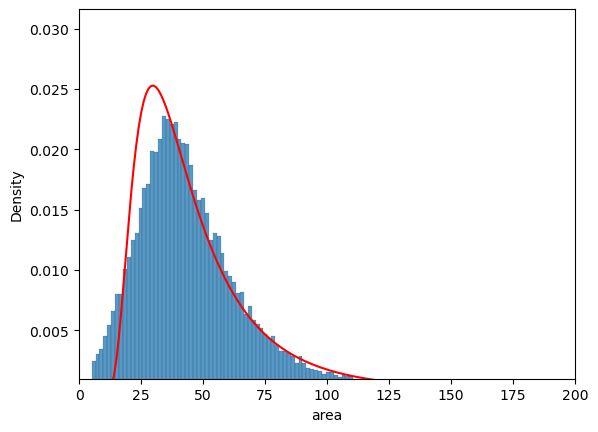

In [141]:
vals = nuclei_size_original.query('condition == "WT"').area.values
params = exponweib.fit(vals, 10, method='MM')

sns.histplot(data=nuclei_size_original.query('condition == "WT"'), x='area', stat='density')
x = np.arange(0, nuclei_size_original.area.max())
rv = exponweib(*params)

plt.plot(x, rv.pdf(x), color='r')
plt.ylim((10 ** -3, 10 ** -1.5))
plt.xlim((0, 200))

print(rv.stats(moments='mvsk'))
print(np.mean(vals), np.std(vals)**2)

In [342]:
nuclei_size_original.iloc[nuclei_size_original.area.argmax()]

area_2D                                    873
eccentricity                          0.875613
equivalent_diameter_area             33.339738
intensity_mean_2D                  8773.151203
label                                      288
z                                           15
area_3D                                   2911
intensity_mean_3D                  7431.833391
area                               1665.122667
volume                            33313.897473
sample_name                 Ndr1219 p8 Hilar-5
condition                                  Ndr
cell_line                                 1219
region                                   Hilar
sample_number                                5
Name: 681, dtype: object

In [146]:
nuclei_size_original.query('area > 750').sort_values('area')

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,area,volume,sample_name,condition,cell_line,region,sample_number
1229,4398,0.916112,74.831193,6186.181446,148,2,17436,4163.471725,754.970050,17958.605452,Ndr1219 p8 peripheral-1,Ndr,1219,Peripheral,1
13091,2528,0.649607,56.734025,7302.830301,337,2,2528,7302.830301,771.487762,11572.316429,Ndr1220 peri repaet EdU DAPI-1,Ndr,1220,Peripheral,1
4303,3449,0.616123,66.267663,7171.543056,232,0,3449,7171.543056,819.463928,12291.958927,Ndr1220 hilar-12,Ndr,1220,Hilar,12
633,443,0.942532,23.749634,11900.995485,21,4,1628,8208.310811,844.959154,18631.063238,Ndr1219 p8 Hilar-5,Ndr,1219,Hilar,5
371,475,0.846949,24.592454,13161.568421,404,2,475,13161.568421,905.994578,5435.967468,Ndr1219 p8 Hilar-11,Ndr,1219,Hilar,11
636,478,0.884311,24.669992,11968.675732,31,4,1975,7460.065823,911.716649,22602.180525,Ndr1219 p8 Hilar-5,Ndr,1219,Hilar,5
686,503,0.870459,25.306906,5312.449304,315,17,503,5312.449304,959.400574,5756.403445,Ndr1219 p8 Hilar-5,Ndr,1219,Hilar,5
1292,12986,0.898721,128.585725,5641.315725,22,1,26068,5471.039052,990.757523,11933.035786,Ndr1219 p8 peripheral-4,Ndr,1219,Peripheral,4
36828,8410,0.834914,103.479199,9907.686683,101,1,8410,9907.686683,1091.628369,16374.425536,Ndr1220 peri repaet EdU DAPI-8,Ndr,1220,Peripheral,8
678,746,0.738855,30.819421,6024.883378,285,16,1772,4991.427201,1422.888327,20279.019691,Ndr1219 p8 Hilar-5,Ndr,1219,Hilar,5


# Test statistical significance

## Test differences between the distributions

We should test the statistical significance between Ndr and WT distributions, but also see the difference in big nuclei found.

In [66]:
from scipy.stats import kstest

In [67]:
condition_palette = {'WT': (61/255, 133/255, 198/255), 'Ndr': (247/255, 137/255, 23/255)}

In [68]:
# nuclei_size_original = nuclei_size_original.query('area < 750')

In [69]:
nuclei_size_original['cond_reg'] = nuclei_size_original.apply(lambda x: '_'.join([x.condition, x.region]), axis=1)

In [70]:
for cond, this_df in nuclei_size_original.groupby('condition'):
    print(cond, len(this_df))
    
for cond, this_df in nuclei_size_original.groupby('cond_reg'):
    print(cond, len(this_df))

Ndr 50165
WT 42650
Ndr_Hilar 15790
Ndr_Peripheral 34375
WT_Hilar 24051
WT_Peripheral 18599


KstestResult(statistic=0.10373403407676118, pvalue=3.163723572197403e-216)


(0.0, 300.0)

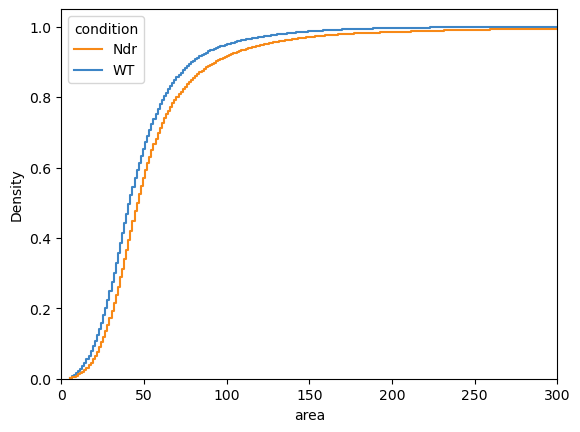

In [22]:
wt_areas = nuclei_size_original.query('condition == "WT"').area.values
ndr_areas = nuclei_size_original.query('condition == "Ndr"').area.values

print(kstest(ndr_areas, wt_areas, alternative='less'))

sns.histplot(data=nuclei_size_original, x='area',  hue='condition', cumulative=True, fill=False, element='step', stat='density', common_norm=False, palette=condition_palette)
plt.xlim(0, 300)

This means that both samples don't come from the same distribution and that Ndr nuclei are bigger with a really low p_valur (pvalue=3.163723572197403e-216)

We should also look into statistical significance region-wise. 

C:\Users\agucor\AppData\Local\Temp\ipykernel_13860\254715506.py:3: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 300)


(3.8990171660842288, 300)

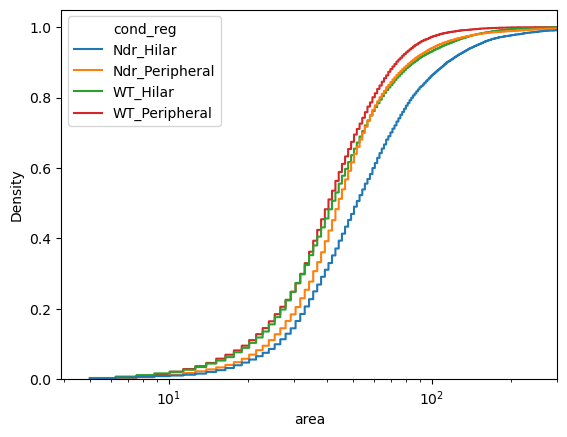

In [64]:
sns.histplot(data=nuclei_size_original.query('area < 750'), x='area',  hue='cond_reg', cumulative=True, fill=False, element='step', stat='density', common_norm=False)
plt.semilogx()
plt.xlim(0, 300)

In [134]:
from itertools import combinations

list(combinations(nuclei_size_original.cond_reg.unique(), 2))

for comb in combinations(nuclei_size_original.cond_reg.unique(), 2):
    print('\n ================== \n')
    print(comb)
    print('Alternative hypothesis: the distributions are different')
    print(kstest(nuclei_size_original.query('cond_reg == "%s"' % comb[0]).area.values, 
                 nuclei_size_original.query('cond_reg == "%s"' % comb[1]).area.values))
    
    print('\n')
    print('Alternative hypothesis: first is bigger than second')
    print(kstest(nuclei_size_original.query('cond_reg == "%s"' % comb[0]).area.values, 
                 nuclei_size_original.query('cond_reg == "%s"' % comb[1]).area.values,
                 alternative='less'))
    
    print('\n')
    print('subsampling 1000 times and KS test')
    print('Alternative hypothesis: first is bigger than second')
    print(small_ks_test(comb[1], comb[0]))
    
    print('\n')
    print('Alternative hypothesis: first is smaller than second')
    print(kstest(nuclei_size_original.query('cond_reg == "%s"' % comb[0]).area.values, 
                 nuclei_size_original.query('cond_reg == "%s"' % comb[1]).area.values, 
                 alternative='greater'))
          
    print('\n')
    print('subsampling 1000 times and KS test')
    print('Alternative hypothesis: first is bigger than second')
    print(small_ks_test(comb[0], comb[1]))



('Ndr_Hilar', 'Ndr_Peripheral')
Alternative hypothesis: the distributions are different
KstestResult(statistic=0.16726225358809488, pvalue=5.855830761261085e-265)


Alternative hypothesis: first is bigger than second
KstestResult(statistic=0.16726225358809488, pvalue=1.2572702123230033e-263)


subsampling 1000 times and KS test
Alternative hypothesis: first is bigger than second
(404, 596)


Alternative hypothesis: first is smaller than second
KstestResult(statistic=0.0019091188360140865, pvalue=0.922638399114373)


subsampling 1000 times and KS test
Alternative hypothesis: first is bigger than second
(3, 997)


('Ndr_Hilar', 'WT_Hilar')
Alternative hypothesis: the distributions are different
KstestResult(statistic=0.1680824987065952, pvalue=8.578635288021826e-236)


Alternative hypothesis: first is bigger than second
KstestResult(statistic=0.1680824987065952, pvalue=1.2219709731245806e-234)


subsampling 1000 times and KS test
Alternative hypothesis: first is bigger than second
(453

In [130]:
def small_ks_test(small_cond, big_cond):
    small_vals = nuclei_size_original.query('cond_reg == "%s"' % small_cond).area.values
    big_vals = nuclei_size_original.query('cond_reg == "%s"' % big_cond).area.values
                                          
    fails = 0
    successes = 0
    for n in range(1000):
        sub_small_areas = np.random.choice(small_vals, 40)
        sub_big_areas = np.random.choice(big_vals, 40)

        test_result = kstest(sub_big_areas, sub_small_areas, alternative='less')
        if test_result.pvalue < 0.05:
            successes += 1
        else:
            fails += 1
    return successes, fails

In [138]:
for n in range(10):
    print(small_ks_test('Ndr_Peripheral', 'Ndr_Peripheral'))

(46, 954)
(47, 953)
(41, 959)
(34, 966)
(50, 950)
(56, 944)
(51, 949)
(64, 936)
(48, 952)
(50, 950)


## Test differences between the amount of big nuclei

Now we should test how each condition and region affects the amount of big nuclei present. We can try different thresholds found with different techniques to assess this.

_Techniques_:

1. Unsupervised thresholding

2. Supervised Thresholding

3. Statistic from WT distribution

In [252]:
thresholds = {'unsupervised_thresholding': 179, 'supervised_thresholding': 181, 'percentile_99': 160, 'alb_pos_weighted': 201}

In [307]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import shapiro
import scipy.stats as stats


import scikit_posthocs as sp

def two_way_anova(sample_df):
    model = ols('big ~ C(condition) + C(region) + C(condition):C(region)', data=sample_df).fit()
    return sm.stats.anova_lm(model, typ=2)

def shapiro_residual_test(sample_df):
    sample_df['residual'] = sample_df.groupby(['condition', 'region']).big.transform(lambda x: x - np.mean(x))
    test_res = shapiro(sample_df.residual.values)
    return test_res.pvalue > 0.05

def dunn_test(sample_df):
    return sp.posthoc_dunn(sample_df, val_col='big', group_col='cond_reg', p_adjust='bonferroni')

def analyze_threshold(df, threshold, normalized=False):
    df['big'] = df.area.values > threshold
    
    if not normalized:
        big_count_df = df.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'cond_reg': 'first', 'big': np.sum})
    else:
        big_count_df = df.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'cond_reg': 'first', 'big': lambda x: np.sum(x)/len(x)})

    sns.swarmplot(data=big_count_df, y='big', x='region', hue='condition', palette=condition_palette, size=3)
    plt.show()
    
    print('Shapiro test')
    passed_shapiro = shapiro_residual_test(big_count_df)
    if passed_shapiro:
        print('passed')
    else:
        print('not pased: We should not use Anova')
    
    if passed_shapiro:
        print('Anova\n-------\n')
        print(two_way_anova(big_count_df))
        
    else:
        print('Dunn\n-------\n')
        print(dunn_test(big_count_df))


def my_odds_ratio(sample_df):
    cross_df = pd.DataFrame(big_count_df.groupby(['condition', 'region']).big.agg(lambda x: np.sum(x > 0) / len(x))).reset_index().pivot('condition', 'region')['big']
    cross_df = cross_df.reindex(index=cross_df.index[::-1])
    
    print(cross_df)
    return stats.fisher_exact(cross_df.values)


def logit_reg(big_count_df):
    has_big_df = big_count_df.copy()
    has_big_df['big'] = has_big_df['big'] > 0
    has_big_df['big'] = has_big_df['big'].astype(int)
    
    print(has_big_df.groupby('cond_reg').agg([sum, len]))

    res1 = smf.logit(formula='big ~ C(condition, Treatment(reference="WT")) + C(region, Treatment(reference="Peripheral")) + C(condition, Treatment(reference="WT")):C(region, Treatment(reference="Peripheral"))', data=has_big_df).fit()
    
    print(res1.summary(xname=('Intercept', 'Ndr', 'Hilar', 'Ndr*Hilar')))
    
    odds_ratios = pd.DataFrame(
        {
            "OR": res1.params,
            "Lower CI": res1.conf_int()[0],
            "Upper CI": res1.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)
    odds_ratios.index = (['Intercept', 'Ndr', 'Hilar', 'Ndr*Hilar'])

    print(odds_ratios)
    

def logit_reg_no_interaction(big_count_df):
    has_big_df = big_count_df.copy()
    has_big_df['big'] = has_big_df['big'] > 0
    has_big_df['big'] = has_big_df['big'].astype(int)
    
    print(has_big_df.groupby('cond_reg').agg([sum, len]))

    res1 = smf.logit(formula='big ~ C(condition, Treatment(reference="WT")) + C(region, Treatment(reference="Peripheral"))', data=has_big_df).fit()
    
    print(res1.summary(xname=('Intercept', 'Ndr', 'Hilar')))
    
    odds_ratios = pd.DataFrame(
        {
            "OR": res1.params,
            "Lower CI": res1.conf_int()[0],
            "Upper CI": res1.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)
    odds_ratios.index = (['Intercept', 'Ndr', 'Hilar'])

    print(odds_ratios)
    
    
def logit_reg_only_gene(big_count_df):
    has_big_df = big_count_df.copy()
    has_big_df['big'] = has_big_df['big'] > 0
    has_big_df['big'] = has_big_df['big'].astype(int)
    
    print(has_big_df.groupby('condition').agg([sum, len]))

    res1 = smf.logit(formula='big ~ C(condition, Treatment(reference="WT"))', data=has_big_df).fit()
    
    print(res1.summary(xname=('Intercept', 'Ndr')))
    
    odds_ratios = pd.DataFrame(
        {
            "OR": res1.params,
            "Lower CI": res1.conf_int()[0],
            "Upper CI": res1.conf_int()[1],
        }
    )
    odds_ratios = np.exp(odds_ratios)
    odds_ratios.index = (['Intercept', 'Ndr'])

    print(odds_ratios)

In [254]:
nuclei_size_original.sample_name.unique()

array(['Ndr1219 p8 Hilar-1', 'Ndr1219 p8 Hilar-11', 'Ndr1219 p8 Hilar-3',
       'Ndr1219 p8 Hilar-5', 'Ndr1219 p8 Hilar-6', 'Ndr1219 p8 Hilar-8',
       'Ndr1219 p8 Hilar-9-10', 'Ndr1219 p8 peripheral-1',
       'Ndr1219 p8 peripheral-4', 'Ndr1219 p8 peripheral-5',
       'Ndr1219 p8 peripheral-6', 'Ndr1219 p8 peripheral-8',
       'Ndr1219 p8 peripheral-9', 'Ndr1220 hilar-11', 'Ndr1220 hilar-12',
       'Ndr1220 hilar-13', 'Ndr1220 hilar-19 full ', 'Ndr1220 hilar-2',
       'Ndr1220 hilar-3', 'Ndr1220 hilar-5', 'Ndr1220 hilar-7',
       'Ndr1220 hilar-9', 'Ndr1220 peri repaet EdU DAPI-1',
       'Ndr1220 peri repaet EdU DAPI-10',
       'Ndr1220 peri repaet EdU DAPI-11',
       'Ndr1220 peri repaet EdU DAPI-13',
       'Ndr1220 peri repaet EdU DAPI-14',
       'Ndr1220 peri repaet EdU DAPI-19',
       'Ndr1220 peri repaet EdU DAPI-2',
       'Ndr1220 peri repaet EdU DAPI-20',
       'Ndr1220 peri repaet EdU DAPI-4', 'Ndr1220 peri repaet EdU DAPI-5',
       'Ndr1220 peri repaet EdU DA

unsupervised_thresholding 179


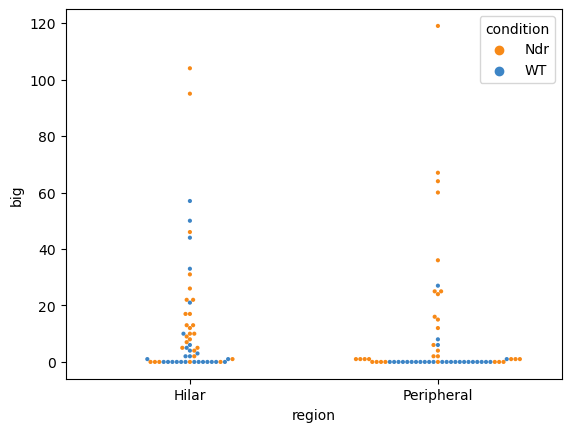

Shapiro test
not pased: We should not use Anova
Dunn
-------

                Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar        1.000000        1.000000  0.078284       0.000006
Ndr_Peripheral   1.000000        1.000000  0.927492       0.000599
WT_Hilar         0.078284        0.927492  1.000000       0.097025
WT_Peripheral    0.000006        0.000599  0.097025       1.000000
supervised_thresholding 181


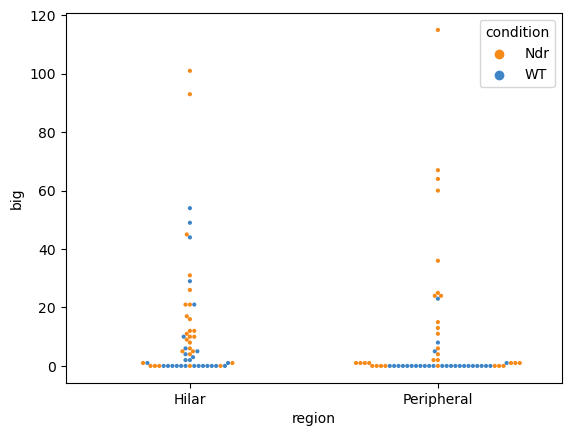

Shapiro test
not pased: We should not use Anova
Dunn
-------

                Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar        1.000000        1.000000  0.087925       0.000006
Ndr_Peripheral   1.000000        1.000000  0.894807       0.000462
WT_Hilar         0.087925        0.894807  1.000000       0.086322
WT_Peripheral    0.000006        0.000462  0.086322       1.000000
percentile_99 160


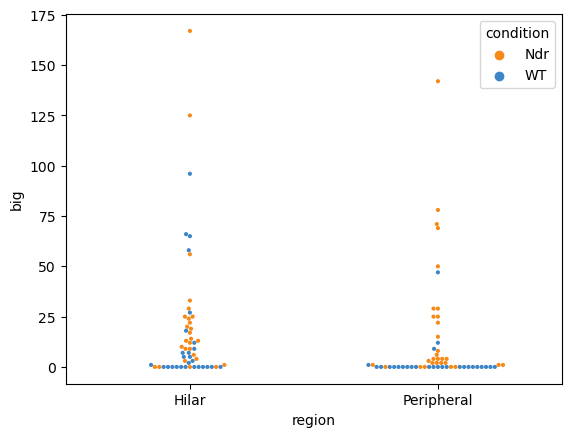

Shapiro test
not pased: We should not use Anova
Dunn
-------

                Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar        1.000000        1.000000  0.098442       0.000002
Ndr_Peripheral   1.000000        1.000000  0.757259       0.000091
WT_Hilar         0.098442        0.757259  1.000000       0.038317
WT_Peripheral    0.000002        0.000091  0.038317       1.000000
alb_pos_weighted 201


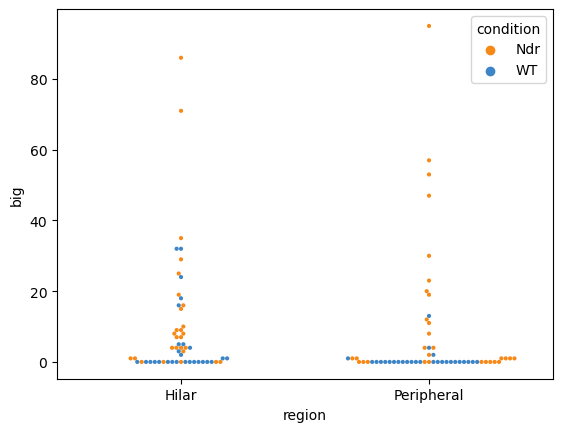

Shapiro test
not pased: We should not use Anova
Dunn
-------

                Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar        1.000000        1.000000  0.030963       0.000006
Ndr_Peripheral   1.000000        1.000000  0.652010       0.000979
WT_Hilar         0.030963        0.652010  1.000000       0.208593
WT_Peripheral    0.000006        0.000979  0.208593       1.000000


In [255]:
for method, threshold in thresholds.items():
    print(method, threshold)
    
    analyze_threshold(nuclei_size_original, threshold)

unsupervised_thresholding 179


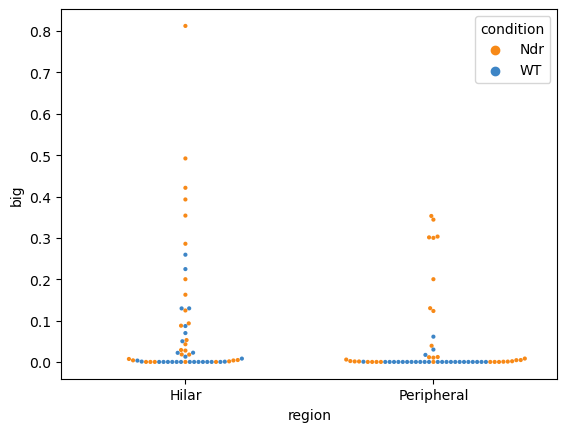

Shapiro test
not pased: We should not use Anova
Dunn
-------

                Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar        1.000000        0.862260  0.052043       0.000002
Ndr_Peripheral   0.862260        1.000000  1.000000       0.000872
WT_Hilar         0.052043        1.000000  1.000000       0.073881
WT_Peripheral    0.000002        0.000872  0.073881       1.000000
supervised_thresholding 181


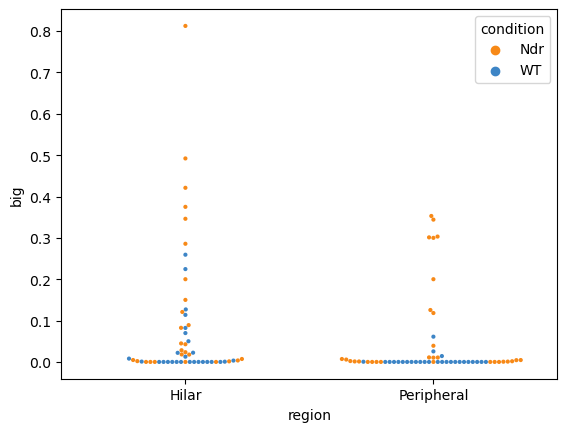

Shapiro test
not pased: We should not use Anova
Dunn
-------

                Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar        1.000000        0.869744  0.054107       0.000002
Ndr_Peripheral   0.869744        1.000000  1.000000       0.000857
WT_Hilar         0.054107        1.000000  1.000000       0.071157
WT_Peripheral    0.000002        0.000857  0.071157       1.000000
percentile_99 160


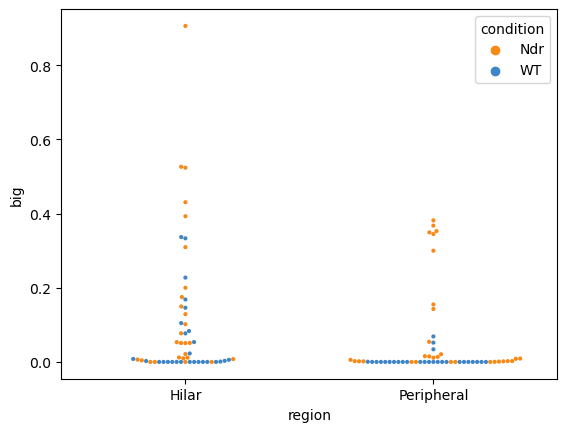

Shapiro test
not pased: We should not use Anova
Dunn
-------

                   Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar       1.000000e+00        1.000000  0.057021   3.747178e-07
Ndr_Peripheral  1.000000e+00        1.000000  1.000000   1.652152e-04
WT_Hilar        5.702063e-02        1.000000  1.000000   2.897263e-02
WT_Peripheral   3.747178e-07        0.000165  0.028973   1.000000e+00
alb_pos_weighted 201


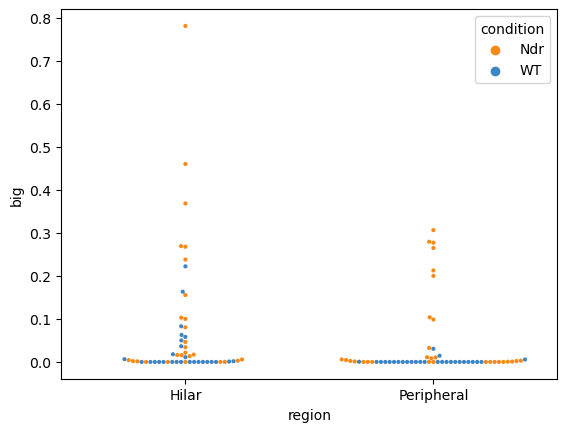

Shapiro test
not pased: We should not use Anova
Dunn
-------

                Ndr_Hilar  Ndr_Peripheral  WT_Hilar  WT_Peripheral
Ndr_Hilar        1.000000        0.670588  0.022882       0.000002
Ndr_Peripheral   0.670588        1.000000  1.000000       0.001703
WT_Hilar         0.022882        1.000000  1.000000       0.169191
WT_Peripheral    0.000002        0.001703  0.169191       1.000000


In [278]:
for method, threshold in thresholds.items():
    print(method, threshold)
    
    analyze_threshold(nuclei_size_original, threshold, normalized=True)

In [284]:
nuclei_size_original['big'] = nuclei_size_original.area.values > 201
normalized = True

if not normalized:
    big_count_df = nuclei_size_original.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'cond_reg': 'first', 'big': np.sum})
else:
    big_count_df = nuclei_size_original.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'cond_reg': 'first', 'big': lambda x: np.sum(x)/len(x)})



In [285]:
big_count_df.to_excel('percentage_of_big_nuclei_per_organoid_alb_pos_trained.xlsx')

In [159]:
nuclei_size_original['big'] = nuclei_size_original.area.values > 181
big_count_df = nuclei_size_original.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'cond_reg': 'first', 'big': np.sum})

C:\Users\agucor\AppData\Local\Temp\ipykernel_28860\2574490770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuclei_size_original['big'] = nuclei_size_original.area.values > 181


In [157]:
for cond, this_df in big_count_df.groupby('condition'):
    print(cond, len(this_df))
    
for cond, this_df in big_count_df.groupby(['condition', 'region']):
    print(cond, len(this_df))

Ndr 57
WT 54
('Ndr', 'Hilar') 27
('Ndr', 'Peripheral') 30
('WT', 'Hilar') 27
('WT', 'Peripheral') 27


In [277]:
for method, threshold in thresholds.items():
    print(method, threshold)
    print('\n ====================== \n')
    
    nuclei_size_original['big'] = nuclei_size_original.area.values > threshold
    big_count_df = nuclei_size_original.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'cond_reg': 'first', 'big': np.sum})
    
    logit_reg(big_count_df)
    print('\n ====================== \n')

unsupervised_thresholding 179


               big    
               sum len
cond_reg              
Ndr_Hilar       22  27
Ndr_Peripheral  22  30
WT_Hilar        14  27
WT_Peripheral    4  27
Optimization terminated successfully.
         Current function value: 0.543761
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    big   No. Observations:                  111
Model:                          Logit   Df Residuals:                      107
Method:                           MLE   Df Model:                            3
Date:                Tue, 04 Apr 2023   Pseudo R-squ.:                  0.2077
Time:                        09:00:30   Log-Likelihood:                -60.357
converged:                       True   LL-Null:                       -76.176
Covariance Type:            nonrobust   LLR p-value:                 6.239e-07
                 coef    std err          z      P>|z|      [0.025      0

C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\910655464.py:62: FutureWarning: ['condition', 'region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('cond_reg').agg([sum, len]))
C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\910655464.py:62: FutureWarning: ['condition', 'region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('cond_reg').agg([sum, len]))
C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\910655464.py:62: FutureWarning: ['condition', 'region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('cond_reg').agg([sum, len]))
C:\Users\agucor\AppData\Loca

In [308]:
for method, threshold in thresholds.items():
    print(method, threshold)
    print('\n ====================== \n')
    
    nuclei_size_original['big'] = nuclei_size_original.area.values > threshold
    big_count_df = nuclei_size_original.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'cond_reg': 'first', 'big': np.sum})
    
    logit_reg_no_interaction(big_count_df)
    print('\n ====================== \n')

unsupervised_thresholding 179


               big    
               sum len
cond_reg              
Ndr_Hilar       22  27
Ndr_Peripheral  22  30
WT_Hilar        14  27
WT_Peripheral    4  27
Optimization terminated successfully.
         Current function value: 0.553480
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    big   No. Observations:                  111
Model:                          Logit   Df Residuals:                      108
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.1935
Time:                        14:09:24   Log-Likelihood:                -61.436
converged:                       True   LL-Null:                       -76.176
Covariance Type:            nonrobust   LLR p-value:                 3.967e-07
                 coef    std err          z      P>|z|      [0.025      0

C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\1257591693.py:86: FutureWarning: ['condition', 'region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('cond_reg').agg([sum, len]))
C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\1257591693.py:86: FutureWarning: ['condition', 'region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('cond_reg').agg([sum, len]))
C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\1257591693.py:86: FutureWarning: ['condition', 'region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('cond_reg').agg([sum, len]))
C:\Users\agucor\AppData\L

In [291]:
for method, threshold in thresholds.items():
    print(method, threshold)
    print('\n ====================== \n')
    
    nuclei_size_original['big'] = nuclei_size_original.area.values > threshold
    big_count_df = nuclei_size_original.groupby('sample_name').agg({'condition': 'first', 'region': 'first', 'cell_line': 'first', 'big': np.sum})
    
    logit_reg_only_gene(big_count_df)
    print('\n ====================== \n')

unsupervised_thresholding 179


          big    
          sum len
condition        
Ndr        44  57
WT         18  54
Optimization terminated successfully.
         Current function value: 0.585378
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    big   No. Observations:                  111
Model:                          Logit   Df Residuals:                      109
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.1470
Time:                        11:46:47   Log-Likelihood:                -64.977
converged:                       True   LL-Null:                       -76.176
Covariance Type:            nonrobust   LLR p-value:                 2.215e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\1314640710.py:110: FutureWarning: ['region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('condition').agg([sum, len]))
C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\1314640710.py:110: FutureWarning: ['region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('condition').agg([sum, len]))
C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\1314640710.py:110: FutureWarning: ['region', 'cell_line'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(has_big_df.groupby('condition').agg([sum, len]))
C:\Users\agucor\AppData\Local\Temp\ipykernel_18264\1314640